## Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
import torchvision

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Utility

In [ ]:
def show_image(batch_of_tensors):
    images = batch_of_tensors[:4]
    images = (images * 0.5) + 0.5  # Unnormalize the images to [0, 1] range
    grid_img = torchvision.utils.make_grid(images, nrow=2)
    plt.figure(figsize=(5, 5))
    plt.imshow(grid_img.permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
    plt.axis('off')
    plt.show()

## Hyperparameters

In [2]:
batch_size = 128
learning_rate = 1e-3
num_epochs = 50
image_size = 32
channels = 3
latent_dim = 128
num_embeddings = 512  # Number of vectors in the codebook
commitment_cost = 0.25  # Beta, the commitment loss weight

## Dataset

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 170498071/170498071 [00:14<00:00, 11599908.88it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


## Vector Quantised Embedding

In [4]:
class VQEmbedding(nn.Module):
    def __init__(self, num_embeddings, embedding_dim):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings

        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.uniform_(-1/self.num_embeddings, 1/self.num_embeddings)

    def forward(self, z):
        b, c, h, w = z.shape
        z_channel_last = z.permute(0, 2, 3, 1)
        z_flattened = z_channel_last.reshape(b*h*w, self.embedding_dim)

        # Calculate distances between z and the codebook embeddings |a-b|²
        distances = (
            torch.sum(z_flattened ** 2, dim=-1, keepdim=True)                 # a²
            + torch.sum(self.embedding.weight.t() ** 2, dim=0, keepdim=True)  # b²
            - 2 * torch.matmul(z_flattened, self.embedding.weight.t())        # -2ab
        )

        # Get the index with the smallest distance
        encoding_indices = torch.argmin(distances, dim=-1)

        # Get the quantized vector
        z_q = self.embedding(encoding_indices)
        z_q = z_q.reshape(b, h, w, self.embedding_dim)
        z_q = z_q.permute(0, 3, 1, 2)

        # Calculate the commitment loss
        loss = F.mse_loss(z_q, z.detach()) + commitment_cost * F.mse_loss(z_q.detach(), z)

        # Straight-through estimator trick for gradient backpropagation
        z_q = z + (z_q - z).detach()

        return z_q, loss, encoding_indices

## Vector Quantised Variational Autoencoder Model

In [5]:
class VQVAE(nn.Module):
    def __init__(self):
        super(VQVAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(channels, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, latent_dim, kernel_size=1)
        )

        # Vector Quantization
        self.vq_layer = VQEmbedding(num_embeddings, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 128, kernel_size=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()  # Output values in range [-1, 1]
        )

    def forward(self, x):
        z_e = self.encoder(x)
        z_q, vq_loss, _ = self.vq_layer(z_e)
        x_recon = self.decoder(z_q)
        return x_recon, vq_loss

## Loss function

In [7]:
def vqvae_loss(recon_x, x, vq_loss):
    recon_loss = F.mse_loss(recon_x, x)
    return recon_loss + vq_loss

## Training

In [ ]:
model = VQVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Epoch 1/50: 100%|██████████| 391/391 [00:22<00:00, 17.25it/s, Loss=0.312]


Epoch [1/50] Average Loss: 0.0072


Epoch 2/50: 100%|██████████| 391/391 [00:19<00:00, 19.76it/s, Loss=0.207]


Epoch [2/50] Average Loss: 0.0021


Epoch 3/50: 100%|██████████| 391/391 [00:20<00:00, 19.18it/s, Loss=0.152]


Epoch [3/50] Average Loss: 0.0014


Epoch 4/50: 100%|██████████| 391/391 [00:21<00:00, 18.08it/s, Loss=0.138]


Epoch [4/50] Average Loss: 0.0012


Epoch 5/50: 100%|██████████| 391/391 [00:19<00:00, 19.70it/s, Loss=0.144]


Epoch [5/50] Average Loss: 0.0011


Epoch 6/50: 100%|██████████| 391/391 [00:20<00:00, 19.06it/s, Loss=0.143]


Epoch [6/50] Average Loss: 0.0011


Epoch 7/50: 100%|██████████| 391/391 [00:19<00:00, 19.83it/s, Loss=0.127]


Epoch [7/50] Average Loss: 0.0010


Epoch 8/50: 100%|██████████| 391/391 [00:20<00:00, 19.05it/s, Loss=0.126]


Epoch [8/50] Average Loss: 0.0010


Epoch 9/50: 100%|██████████| 391/391 [00:23<00:00, 16.68it/s, Loss=0.121]


Epoch [9/50] Average Loss: 0.0010


Epoch 10/50: 100%|██████████| 391/391 [00:19<00:00, 19.88it/s, Loss=0.119]


Epoch [10/50] Average Loss: 0.0010


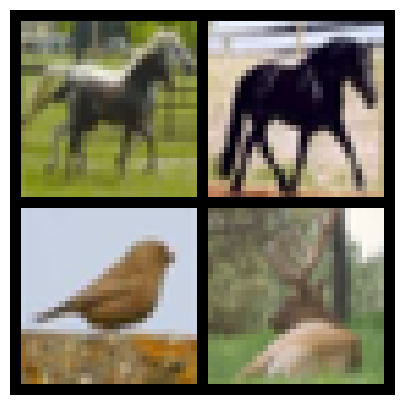

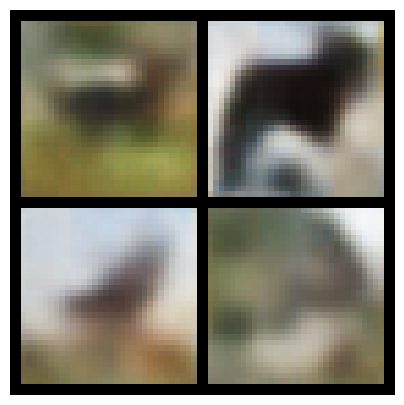

Epoch 11/50: 100%|██████████| 391/391 [00:20<00:00, 18.63it/s, Loss=0.124]


Epoch [11/50] Average Loss: 0.0010


Epoch 12/50: 100%|██████████| 391/391 [00:20<00:00, 18.80it/s, Loss=0.123]


Epoch [12/50] Average Loss: 0.0010


Epoch 13/50: 100%|██████████| 391/391 [00:20<00:00, 19.01it/s, Loss=0.114]


Epoch [13/50] Average Loss: 0.0010


Epoch 14/50: 100%|██████████| 391/391 [00:20<00:00, 18.68it/s, Loss=0.118]


Epoch [14/50] Average Loss: 0.0010


Epoch 15/50: 100%|██████████| 391/391 [00:20<00:00, 19.07it/s, Loss=0.126]


Epoch [15/50] Average Loss: 0.0009


Epoch 16/50: 100%|██████████| 391/391 [00:20<00:00, 19.02it/s, Loss=0.123]


Epoch [16/50] Average Loss: 0.0009


Epoch 17/50: 100%|██████████| 391/391 [00:21<00:00, 18.61it/s, Loss=0.12]


Epoch [17/50] Average Loss: 0.0009


Epoch 18/50: 100%|██████████| 391/391 [00:20<00:00, 19.41it/s, Loss=0.116]


Epoch [18/50] Average Loss: 0.0009


Epoch 19/50: 100%|██████████| 391/391 [00:21<00:00, 18.57it/s, Loss=0.112]


Epoch [19/50] Average Loss: 0.0009


Epoch 20/50: 100%|██████████| 391/391 [00:21<00:00, 18.53it/s, Loss=0.117]


Epoch [20/50] Average Loss: 0.0009


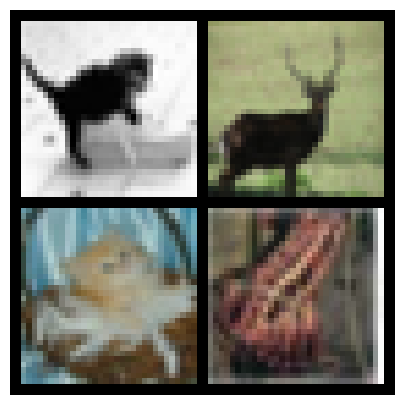

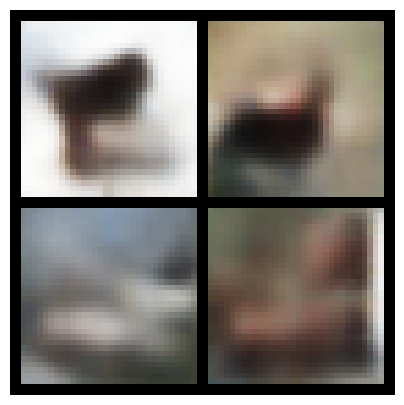

Epoch 21/50: 100%|██████████| 391/391 [00:20<00:00, 19.22it/s, Loss=0.123]


Epoch [21/50] Average Loss: 0.0009


Epoch 22/50: 100%|██████████| 391/391 [00:21<00:00, 18.44it/s, Loss=0.128]


Epoch [22/50] Average Loss: 0.0010


Epoch 23/50: 100%|██████████| 391/391 [00:20<00:00, 18.72it/s, Loss=0.126]


Epoch [23/50] Average Loss: 0.0010


Epoch 24/50: 100%|██████████| 391/391 [00:20<00:00, 18.82it/s, Loss=0.123]


Epoch [24/50] Average Loss: 0.0010


Epoch 25/50: 100%|██████████| 391/391 [00:21<00:00, 18.47it/s, Loss=0.126]


Epoch [25/50] Average Loss: 0.0010


Epoch 26/50: 100%|██████████| 391/391 [00:20<00:00, 18.91it/s, Loss=0.122]


Epoch [26/50] Average Loss: 0.0010


Epoch 27/50: 100%|██████████| 391/391 [00:21<00:00, 18.53it/s, Loss=0.123]


Epoch [27/50] Average Loss: 0.0010


Epoch 28/50: 100%|██████████| 391/391 [00:21<00:00, 18.47it/s, Loss=0.12]


Epoch [28/50] Average Loss: 0.0010


Epoch 29/50: 100%|██████████| 391/391 [00:20<00:00, 18.99it/s, Loss=0.12]


Epoch [29/50] Average Loss: 0.0009


Epoch 30/50: 100%|██████████| 391/391 [00:21<00:00, 18.41it/s, Loss=0.121]


Epoch [30/50] Average Loss: 0.0009


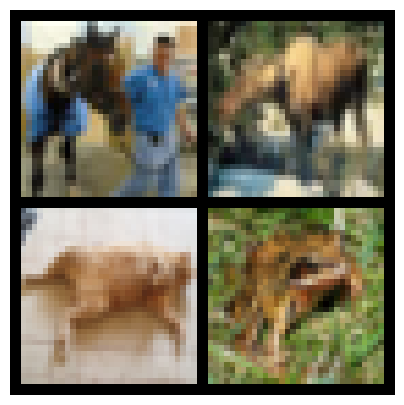

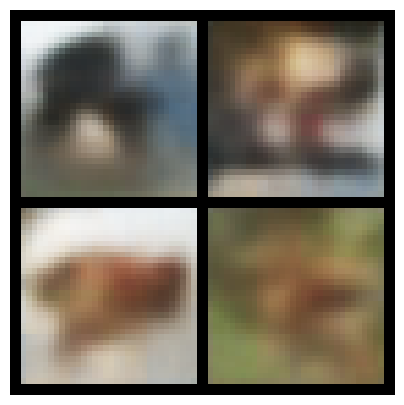

Epoch 31/50: 100%|██████████| 391/391 [00:21<00:00, 18.42it/s, Loss=0.127]


Epoch [31/50] Average Loss: 0.0009


Epoch 32/50: 100%|██████████| 391/391 [00:20<00:00, 18.83it/s, Loss=0.141]


Epoch [32/50] Average Loss: 0.0009


Epoch 33/50: 100%|██████████| 391/391 [00:21<00:00, 18.36it/s, Loss=0.123]


Epoch [33/50] Average Loss: 0.0009


Epoch 34/50: 100%|██████████| 391/391 [00:20<00:00, 19.22it/s, Loss=0.115]


Epoch [34/50] Average Loss: 0.0009


Epoch 35/50: 100%|██████████| 391/391 [00:21<00:00, 18.48it/s, Loss=0.115]


Epoch [35/50] Average Loss: 0.0009


Epoch 36/50: 100%|██████████| 391/391 [00:21<00:00, 18.47it/s, Loss=0.112]


Epoch [36/50] Average Loss: 0.0009


Epoch 37/50: 100%|██████████| 391/391 [00:20<00:00, 19.17it/s, Loss=0.125]


Epoch [37/50] Average Loss: 0.0009


Epoch 38/50: 100%|██████████| 391/391 [00:21<00:00, 18.49it/s, Loss=0.125]


Epoch [38/50] Average Loss: 0.0009


Epoch 39/50: 100%|██████████| 391/391 [00:20<00:00, 18.65it/s, Loss=0.114]


Epoch [39/50] Average Loss: 0.0009


Epoch 40/50: 100%|██████████| 391/391 [00:20<00:00, 19.07it/s, Loss=0.118]


Epoch [40/50] Average Loss: 0.0009


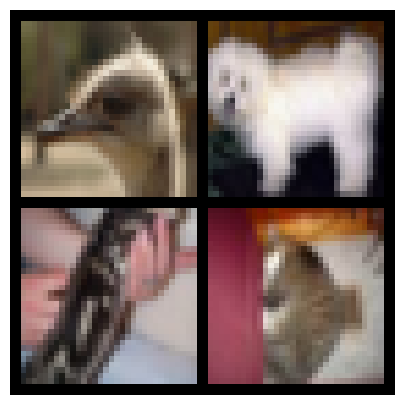

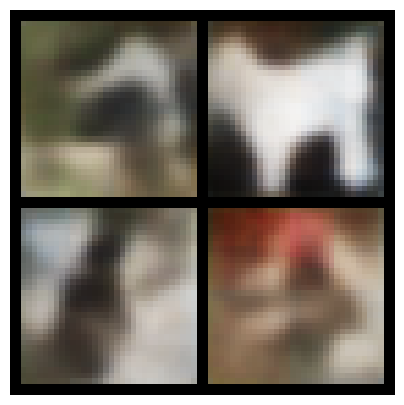

Epoch 41/50: 100%|██████████| 391/391 [00:21<00:00, 18.32it/s, Loss=0.114]


Epoch [41/50] Average Loss: 0.0009


Epoch 42/50: 100%|██████████| 391/391 [00:20<00:00, 18.69it/s, Loss=0.113]


Epoch [42/50] Average Loss: 0.0009


Epoch 43/50: 100%|██████████| 391/391 [00:21<00:00, 18.47it/s, Loss=0.105]


Epoch [43/50] Average Loss: 0.0009


Epoch 44/50: 100%|██████████| 391/391 [00:21<00:00, 18.18it/s, Loss=0.115]


Epoch [44/50] Average Loss: 0.0009


Epoch 45/50: 100%|██████████| 391/391 [00:20<00:00, 19.02it/s, Loss=0.111]


Epoch [45/50] Average Loss: 0.0009


Epoch 46/50: 100%|██████████| 391/391 [00:21<00:00, 18.39it/s, Loss=0.109]


Epoch [46/50] Average Loss: 0.0009


Epoch 47/50: 100%|██████████| 391/391 [00:21<00:00, 18.32it/s, Loss=0.116]


Epoch [47/50] Average Loss: 0.0009


Epoch 48/50: 100%|██████████| 391/391 [00:20<00:00, 18.98it/s, Loss=0.113]


Epoch [48/50] Average Loss: 0.0009


Epoch 49/50: 100%|██████████| 391/391 [00:21<00:00, 18.38it/s, Loss=0.109]


Epoch [49/50] Average Loss: 0.0009


Epoch 50/50: 100%|██████████| 391/391 [00:21<00:00, 18.48it/s, Loss=0.123]


Epoch [50/50] Average Loss: 0.0009


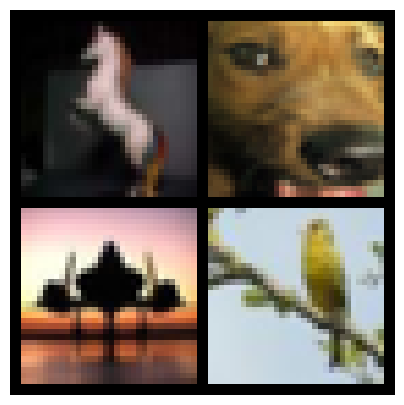

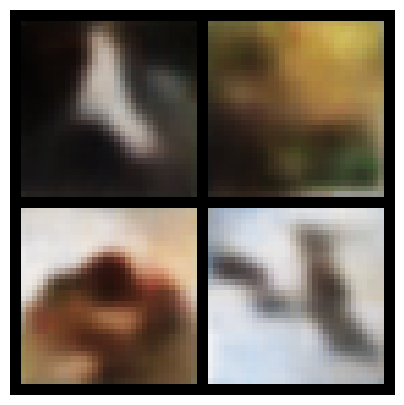

In [9]:
# Training Loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    # Use tqdm for the progress bar
    pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}')

    for batch_idx, (data, _) in pbar:
        data = data.to(device)

        optimizer.zero_grad()
        recon_batch, vq_loss = model(data)
        loss = vqvae_loss(recon_batch, data, vq_loss)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        # Update tqdm description with current loss
        pbar.set_postfix({'Loss': loss.item()})

    avg_loss = train_loss / len(train_loader.dataset)
    print(f'Epoch [{epoch + 1}/{num_epochs}] Average Loss: {avg_loss:.4f}')

    # Save and display a sample of the reconstructed images
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            recon_batch, _ = model(data)
            show_image(data.cpu())
            show_image(recon_batch.cpu())